2025-08-06 06:04:07,060 - INFO - === Instagram Content Analytics Started ===
2025-08-06 06:04:07,065 - INFO - Loading data from data_cleaned_batik_tekstil.xlsx
2025-08-06 06:04:07,866 - INFO - Data loaded successfully. Shape: (364, 23)
2025-08-06 06:04:07,873 - WARNING - Removing 9 rows with invalid likes
2025-08-06 06:04:07,873 - INFO - Data validation completed successfully
2025-08-06 06:04:07,883 - INFO - Starting data preprocessing
2025-08-06 06:04:07,922 - INFO - Data preprocessing completed
2025-08-06 06:04:07,922 - INFO - Performing statistical analysis
2025-08-06 06:04:07,971 - INFO - Statistical analysis completed
2025-08-06 06:04:07,971 - INFO - Creating visualizations
2025-08-06 06:04:11,380 - INFO - Visualization saved to analytics_output\instagram_analytics_20250806_060408.png


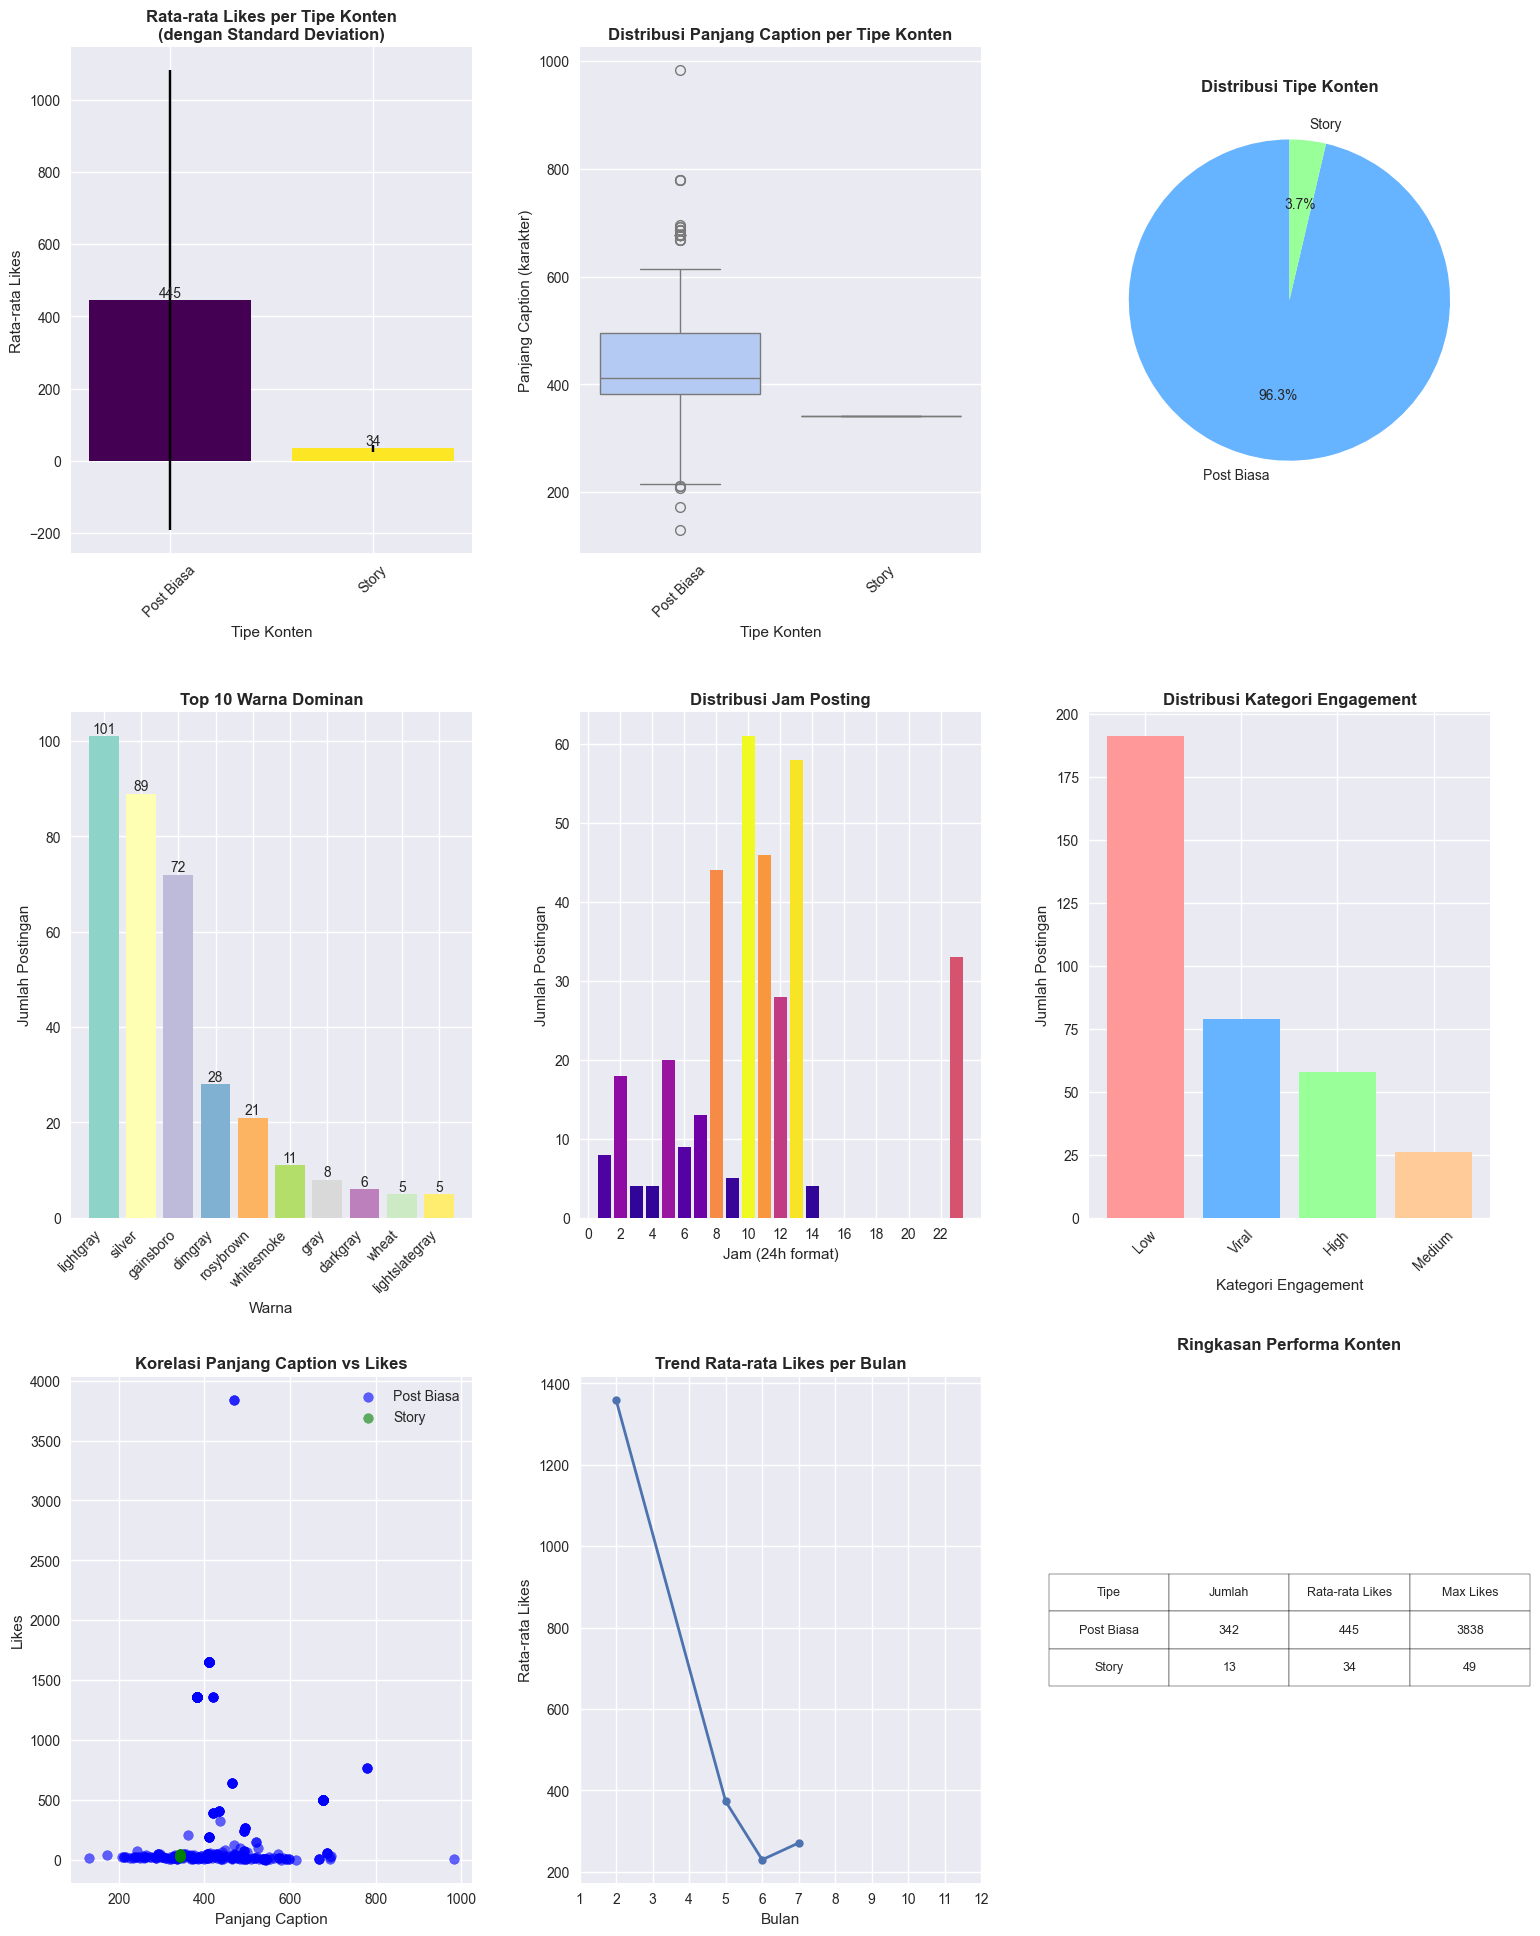

2025-08-06 06:04:12,669 - INFO - Results exported to analytics_output\instagram_analytics_results_20250806_060412.xlsx
2025-08-06 06:04:12,669 - INFO - === ANALYSIS SUMMARY ===
2025-08-06 06:04:12,672 - INFO - Total posts analyzed: 355
2025-08-06 06:04:12,672 - INFO - Content types found: ['Post Biasa', 'Story']
2025-08-06 06:04:12,672 - INFO - Best performing content type: Post Biasa
2025-08-06 06:04:12,672 - INFO - === Instagram Content Analytics Completed Successfully ===


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging
from datetime import datetime
from pathlib import Path
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# ============= CONFIGURATION =============
CONFIG = {
    'file_path': 'data_cleaned_batik_tekstil.xlsx',
    'output_dir': 'analytics_output',
    'figure_size': (16, 20),
    'top_colors_count': 10,
    'dpi': 300,
    'style': 'seaborn-v0_8',
    'color_palettes': {
        'likes': 'viridis',
        'caption': 'coolwarm',
        'pie': ['#66b3ff', '#99ff99', '#ffcc99'],
        'colors': 'Set3',
        'hours': 'plasma'
    }
}

# ============= LOGGING SETUP =============
def setup_logging():
    """Setup logging configuration"""
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler('instagram_analytics.log'),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)

# ============= DATA LOADING & VALIDATION =============
def load_and_validate_data(file_path):
    """
    Load data from Excel file with comprehensive validation
    
    Args:
        file_path (str): Path to the Excel file
        
    Returns:
        pd.DataFrame: Validated dataframe
    """
    logger = logging.getLogger(__name__)
    
    try:
        # Check if file exists
        if not Path(file_path).exists():
            raise FileNotFoundError(f"File tidak ditemukan: {file_path}")
        
        # Load data
        logger.info(f"Loading data from {file_path}")
        df = pd.read_excel(file_path)
        logger.info(f"Data loaded successfully. Shape: {df.shape}")
        
        # Validate required columns
        required_columns = ['caption', 'likes', 'color_name', 'upload_time']
        missing_columns = [col for col in required_columns if col not in df.columns]
        
        if missing_columns:
            raise ValueError(f"Kolom yang diperlukan tidak ditemukan: {missing_columns}")
        
        # Basic data validation
        if df.empty:
            raise ValueError("Dataset kosong")
        
        # Check data types and convert if necessary
        df['likes'] = pd.to_numeric(df['likes'], errors='coerce')
        
        # Remove rows with invalid likes (negative or NaN after conversion)
        invalid_likes = df['likes'].isna() | (df['likes'] < 0)
        if invalid_likes.sum() > 0:
            logger.warning(f"Removing {invalid_likes.sum()} rows with invalid likes")
            df = df[~invalid_likes].copy()
        
        logger.info("Data validation completed successfully")
        return df
        
    except Exception as e:
        logger.error(f"Error loading data: {str(e)}")
        raise

# ============= DATA PREPROCESSING =============
def preprocess_data(df):
    """
    Preprocess the dataframe with advanced content classification
    
    Args:
        df (pd.DataFrame): Raw dataframe
        
    Returns:
        pd.DataFrame: Preprocessed dataframe
    """
    logger = logging.getLogger(__name__)
    logger.info("Starting data preprocessing")
    
    # Handle missing values
    df = df.copy()
    df['color_name'] = df['color_name'].fillna('tidak_diketahui')
    df['caption'] = df['caption'].fillna('')
    
    # Advanced content classification
    df['tipe_konten'] = df['caption'].apply(classify_content_type)
    
    # Feature engineering
    df['caption_length'] = df['caption'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
    
    # Extract posting hour with error handling
    try:
        df['jam_posting'] = pd.to_datetime(df['upload_time'], errors='coerce').dt.hour
        invalid_time = df['jam_posting'].isna()
        if invalid_time.sum() > 0:
            logger.warning(f"Found {invalid_time.sum()} rows with invalid upload_time")
    except Exception as e:
        logger.error(f"Error processing upload_time: {e}")
        df['jam_posting'] = np.nan
    
    # Create engagement categories
    df['engagement_category'] = pd.cut(
        df['likes'], 
        bins=[0, 50, 200, 1000, float('inf')], 
        labels=['Low', 'Medium', 'High', 'Viral']
    )
    
    logger.info("Data preprocessing completed")
    return df

def classify_content_type(caption):
    """
    Advanced content classification based on caption analysis
    
    Args:
        caption (str): Post caption
        
    Returns:
        str: Content type classification
    """
    if pd.isna(caption) or caption == '':
        return 'Unknown'
    
    caption_lower = str(caption).lower()
    
    # Define keywords for different content types
    reel_keywords = ['reel', 'reels', '#reel', 'video', 'tiktok', 'viral', 'trending']
    story_keywords = ['story', 'stories', '#story']
    igtv_keywords = ['igtv', 'long video', 'episode']
    
    # Classification logic
    if any(keyword in caption_lower for keyword in reel_keywords):
        return 'Reel'
    elif any(keyword in caption_lower for keyword in story_keywords):
        return 'Story'
    elif any(keyword in caption_lower for keyword in igtv_keywords):
        return 'IGTV'
    else:
        return 'Post Biasa'

# ============= STATISTICAL ANALYSIS =============
def perform_statistical_analysis(df):
    """
    Perform comprehensive statistical analysis
    
    Args:
        df (pd.DataFrame): Preprocessed dataframe
        
    Returns:
        dict: Dictionary containing analysis results
    """
    logger = logging.getLogger(__name__)
    logger.info("Performing statistical analysis")
    
    try:
        results = {}
        
        # Basic statistics by content type
        results['avg_likes'] = df.groupby('tipe_konten')['likes'].agg(['mean', 'median', 'std']).reset_index()
        results['avg_caption_length'] = df.groupby('tipe_konten')['caption_length'].agg(['mean', 'median']).reset_index()
        
        # Content distribution
        results['content_distribution'] = df['tipe_konten'].value_counts()
        results['content_percentage'] = (results['content_distribution'] / len(df)) * 100
        
        # Color analysis
        results['top_colors'] = df['color_name'].value_counts().head(CONFIG['top_colors_count'])
        
        # Posting hour analysis
        results['posting_hours'] = df['jam_posting'].value_counts().sort_index()
        
        # Engagement analysis
        results['engagement_by_type'] = df.groupby('tipe_konten')['engagement_category'].value_counts()
        
        # Best performing content
        results['top_posts'] = df.nlargest(10, 'likes')[['tipe_konten', 'likes', 'caption_length', 'color_name']]
        
        logger.info("Statistical analysis completed")
        return results
        
    except Exception as e:
        logger.error(f"Error in statistical analysis: {e}")
        raise

# ============= VISUALIZATION =============
def create_visualizations(df, analysis_results):
    """
    Create comprehensive visualizations
    
    Args:
        df (pd.DataFrame): Preprocessed dataframe
        analysis_results (dict): Statistical analysis results
    """
    logger = logging.getLogger(__name__)
    logger.info("Creating visualizations")
    
    # Set style
    plt.style.use(CONFIG['style'])
    fig = plt.figure(figsize=CONFIG['figure_size'])
    
    # 1. Average Likes Comparison with Error Bars
    plt.subplot(3, 3, 1)
    avg_likes_data = analysis_results['avg_likes']
    bars = plt.bar(avg_likes_data['tipe_konten'], avg_likes_data['mean'], 
                   yerr=avg_likes_data['std'], capsize=5, 
                   color=plt.cm.viridis(np.linspace(0, 1, len(avg_likes_data))))
    plt.title('Rata-rata Likes per Tipe Konten\n(dengan Standard Deviation)', fontsize=12, fontweight='bold')
    plt.ylabel('Rata-rata Likes')
    plt.xlabel('Tipe Konten')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}', ha='center', va='bottom')
    
    # 2. Caption Length Analysis
    plt.subplot(3, 3, 2)
    sns.boxplot(data=df, x='tipe_konten', y='caption_length', palette=CONFIG['color_palettes']['caption'])
    plt.title('Distribusi Panjang Caption per Tipe Konten', fontsize=12, fontweight='bold')
    plt.ylabel('Panjang Caption (karakter)')
    plt.xlabel('Tipe Konten')
    plt.xticks(rotation=45)
    
    # 3. Content Distribution Pie Chart
    plt.subplot(3, 3, 3)
    colors = CONFIG['color_palettes']['pie']
    wedges, texts, autotexts = plt.pie(analysis_results['content_percentage'], 
                                      labels=analysis_results['content_percentage'].index,
                                      autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title('Distribusi Tipe Konten', fontsize=12, fontweight='bold')
    
    # 4. Top Colors Analysis
    plt.subplot(3, 3, 4)
    top_colors = analysis_results['top_colors']
    bars = plt.bar(range(len(top_colors)), top_colors.values, 
                   color=plt.cm.Set3(np.linspace(0, 1, len(top_colors))))
    plt.title(f'Top {CONFIG["top_colors_count"]} Warna Dominan', fontsize=12, fontweight='bold')
    plt.ylabel('Jumlah Postingan')
    plt.xlabel('Warna')
    plt.xticks(range(len(top_colors)), top_colors.index, rotation=45, ha='right')
    
    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height}', ha='center', va='bottom')
    
    # 5. Posting Hours Heatmap Style
    plt.subplot(3, 3, 5)
    hours_data = analysis_results['posting_hours']
    plt.bar(hours_data.index, hours_data.values, 
            color=plt.cm.plasma(hours_data.values / hours_data.max()))
    plt.title('Distribusi Jam Posting', fontsize=12, fontweight='bold')
    plt.xlabel('Jam (24h format)')
    plt.ylabel('Jumlah Postingan')
    plt.xticks(range(0, 24, 2))
    
    # 6. Engagement Distribution
    plt.subplot(3, 3, 6)
    engagement_counts = df['engagement_category'].value_counts()
    plt.bar(engagement_counts.index, engagement_counts.values, 
            color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
    plt.title('Distribusi Kategori Engagement', fontsize=12, fontweight='bold')
    plt.ylabel('Jumlah Postingan')
    plt.xlabel('Kategori Engagement')
    plt.xticks(rotation=45)
    
    # 7. Likes vs Caption Length Scatter
    plt.subplot(3, 3, 7)
    colors_map = {'Reel': 'red', 'Post Biasa': 'blue', 'Story': 'green', 'IGTV': 'orange', 'Unknown': 'gray'}
    for content_type in df['tipe_konten'].unique():
        subset = df[df['tipe_konten'] == content_type]
        plt.scatter(subset['caption_length'], subset['likes'], 
                   alpha=0.6, label=content_type, 
                   color=colors_map.get(content_type, 'gray'))
    plt.title('Korelasi Panjang Caption vs Likes', fontsize=12, fontweight='bold')
    plt.xlabel('Panjang Caption')
    plt.ylabel('Likes')
    plt.legend()
    
    # 8. Monthly Trend (if date data available)
    plt.subplot(3, 3, 8)
    try:
        df['month'] = pd.to_datetime(df['upload_time'], errors='coerce').dt.month
        monthly_likes = df.groupby('month')['likes'].mean()
        plt.plot(monthly_likes.index, monthly_likes.values, marker='o', linewidth=2, markersize=6)
        plt.title('Trend Rata-rata Likes per Bulan', fontsize=12, fontweight='bold')
        plt.xlabel('Bulan')
        plt.ylabel('Rata-rata Likes')
        plt.xticks(range(1, 13))
    except:
        plt.text(0.5, 0.5, 'Data tanggal tidak valid\nuntuk analisis trend', 
                transform=plt.gca().transAxes, ha='center', va='center')
        plt.title('Trend Analysis (Data Invalid)', fontsize=12, fontweight='bold')
    
    # 9. Performance Summary Table
    plt.subplot(3, 3, 9)
    plt.axis('off')
    
    # Create summary statistics
    summary_stats = []
    for content_type in df['tipe_konten'].unique():
        subset = df[df['tipe_konten'] == content_type]
        stats = {
            'Type': content_type,
            'Count': len(subset),
            'Avg Likes': f"{subset['likes'].mean():.0f}",
            'Max Likes': f"{subset['likes'].max():.0f}"
        }
        summary_stats.append(stats)
    
    summary_df = pd.DataFrame(summary_stats)
    table_data = []
    for _, row in summary_df.iterrows():
        table_data.append([row['Type'], row['Count'], row['Avg Likes'], row['Max Likes']])
    
    table = plt.table(cellText=table_data,
                     colLabels=['Tipe', 'Jumlah', 'Rata-rata Likes', 'Max Likes'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 2)
    plt.title('Ringkasan Performa Konten', fontsize=12, fontweight='bold', pad=20)
    
    plt.tight_layout(pad=3.0)
    
    # Save the plot
    output_dir = Path(CONFIG['output_dir'])
    output_dir.mkdir(exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = output_dir / f"instagram_analytics_{timestamp}.png"
    plt.savefig(filename, dpi=CONFIG['dpi'], bbox_inches='tight')
    logger.info(f"Visualization saved to {filename}")
    
    plt.show()

# ============= EXPORT RESULTS =============
def export_results(df, analysis_results):
    """
    Export analysis results to Excel file
    
    Args:
        df (pd.DataFrame): Processed dataframe
        analysis_results (dict): Analysis results
    """
    logger = logging.getLogger(__name__)
    
    try:
        output_dir = Path(CONFIG['output_dir'])
        output_dir.mkdir(exist_ok=True)
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = output_dir / f"instagram_analytics_results_{timestamp}.xlsx"
        
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            # Main dataset
            df.to_excel(writer, sheet_name='Processed_Data', index=False)
            
            # Analysis results
            analysis_results['avg_likes'].to_excel(writer, sheet_name='Avg_Likes_by_Type', index=False)
            analysis_results['top_colors'].to_excel(writer, sheet_name='Top_Colors')
            analysis_results['posting_hours'].to_excel(writer, sheet_name='Posting_Hours')
            analysis_results['top_posts'].to_excel(writer, sheet_name='Top_Posts', index=False)
        
        logger.info(f"Results exported to {filename}")
        
    except Exception as e:
        logger.error(f"Error exporting results: {e}")

# ============= MAIN EXECUTION =============
def main():
    """Main execution function"""
    logger = setup_logging()
    
    try:
        logger.info("=== Instagram Content Analytics Started ===")
        
        # Load and validate data
        df = load_and_validate_data(CONFIG['file_path'])
        
        # Preprocess data
        df_processed = preprocess_data(df)
        
        # Perform statistical analysis
        analysis_results = perform_statistical_analysis(df_processed)
        
        # Create visualizations
        create_visualizations(df_processed, analysis_results)
        
        # Export results
        export_results(df_processed, analysis_results)
        
        # Print summary
        logger.info("=== ANALYSIS SUMMARY ===")
        logger.info(f"Total posts analyzed: {len(df_processed)}")
        logger.info(f"Content types found: {list(analysis_results['content_distribution'].index)}")
        logger.info(f"Best performing content type: {analysis_results['avg_likes'].loc[analysis_results['avg_likes']['mean'].idxmax(), 'tipe_konten']}")
        
        logger.info("=== Instagram Content Analytics Completed Successfully ===")
        
    except Exception as e:
        logger.error(f"Analysis failed: {str(e)}")
        raise

if __name__ == "__main__":
    main()